
# Práctica 2: Implementación de Algoritmos  
**Grado en Inteligencia Artificial**  
**Guillermo Blanco Núñez**<br>
*16/11/2025*

La práctica consiste en implementar operaciones de procesado de imagen vistas en clase con el objetivo de comprender su funcionamiento y sus efectos sobre las imagenes de entrada.

---


In [31]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import io, img_as_float
from numpy.fft import fft2, ifft2, fftshift
from scipy.signal.windows import gaussian
from scipy.ndimage import gaussian_filter


## 2.1. Filtrado espacial: suavizado

### Función 1: 

Implementar una función que calcule un kernel Gaussiano unidimensional con σ dado.

In [32]:

def gaussianFilterSpatial1D(sigma):
    if sigma <= 0:
        raise ValueError("sigma debe ser > 0")

    N = int(2 * np.ceil(3 * sigma) + 1)
    center = N // 2
    kernel = np.zeros(N)
    for i in range(N):
        x = i - center
        kernel[i] = np.exp(-(x**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

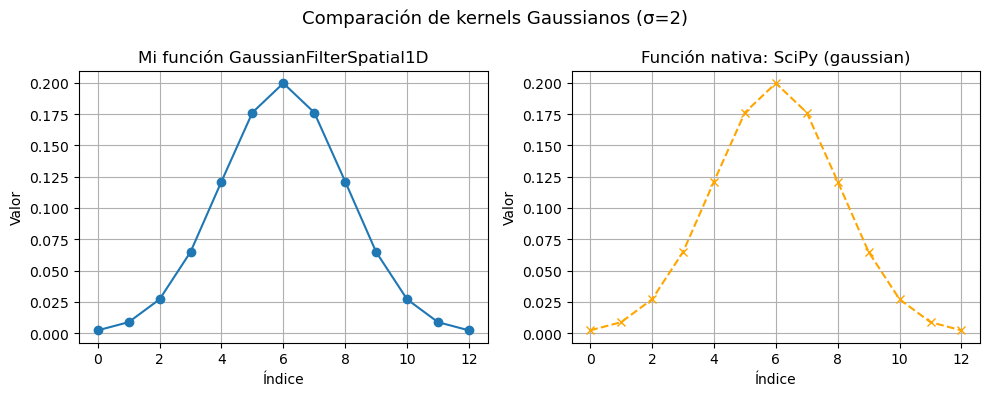

Vector de diferencias: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [33]:
# Ejemplo
sigma = 2


my_kernel = gaussianFilterSpatial1D(sigma)
N = int(2 * np.ceil(3 * sigma) + 1)
native_kernel = gaussian(N, std=sigma)
native_kernel /= np.sum(native_kernel)


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(my_kernel, marker='o')
axes[0].set_title('Mi función GaussianFilterSpatial1D')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('Valor')
axes[0].grid(True)

axes[1].plot(native_kernel, color='orange', linestyle='--', marker='x')
axes[1].set_title('Función nativa: SciPy (gaussian)')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Valor')
axes[1].grid(True)

plt.suptitle(f'Comparación de kernels Gaussianos (σ={sigma})', fontsize=13)
plt.tight_layout()
plt.show()



print("Vector de diferencias:", np.abs(my_kernel - native_kernel))

### Función 2:

Implementar una función que permita realizar un suavizado Gaussiano bidimensional usando un filtro N × N de parámetro σ, donde N se calcula igual que en la función anterior.

In [34]:

def ApplyGaussianFilterSpatial(inImage, sigma):
    kernel = gaussianFilterSpatial1D(sigma)
    temp = convolve2d(inImage, kernel[np.newaxis, :], mode='same', boundary='symm')
    outImage = convolve2d(temp, kernel[:, np.newaxis], mode='same', boundary='symm')
    return outImage

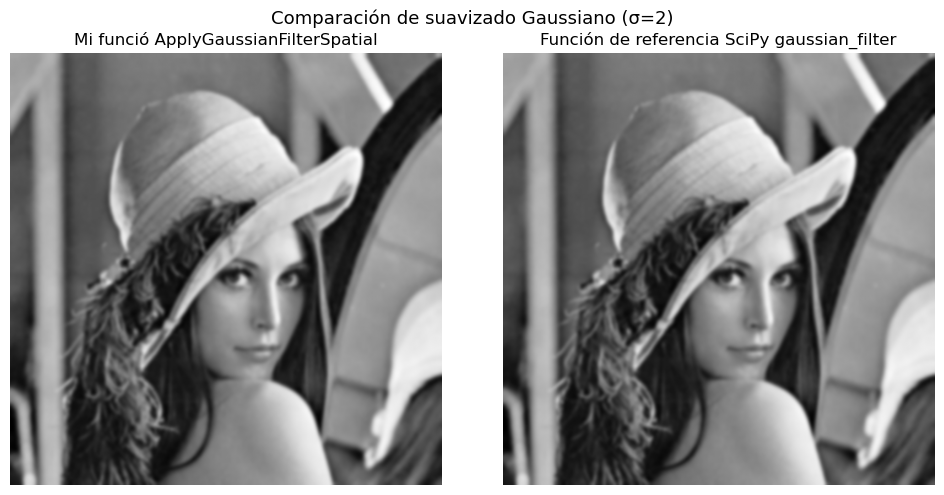

¿Son casi iguales?: True
Diferencia media absoluta: 6.861553770928318e-05


In [35]:
# Ejemplo
test_img = img_as_float(io.imread('../PVC_Pract1/Material Adicional/lena.png', as_gray=True))
my_filtered = ApplyGaussianFilterSpatial(test_img, sigma)
ref_filtered = gaussian_filter(test_img, sigma=sigma)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(my_filtered, cmap='gray')
axes[0].set_title('Mi funció ApplyGaussianFilterSpatial')
axes[0].axis('off')

axes[1].imshow(ref_filtered, cmap='gray')
axes[1].set_title('Función de referencia SciPy gaussian_filter')
axes[1].axis('off')

plt.suptitle(f'Comparación de suavizado Gaussiano (σ={sigma})', fontsize=13)
plt.tight_layout()
plt.show()



print("¿Son casi iguales?:", np.allclose(my_filtered, ref_filtered, atol=1e-3))
print("Diferencia media absoluta:", np.mean(np.abs(my_filtered - ref_filtered)))


###  Función 3: 

Implementar una función que calcule un filtro gaussiano en frecuencia, de tamaño N × M y un σ dado.

In [36]:

def gaussianFilterFrec(inImage, sigma):
    N, M = inImage.shape[:2]
    u = np.arange(-N//2, N//2)
    v = np.arange(-M//2, M//2)
    U, V = np.meshgrid(v, u)
    D = np.sqrt(U**2 + V**2)
    H = np.exp(-(D**2) / (2 * sigma**2))
    return H



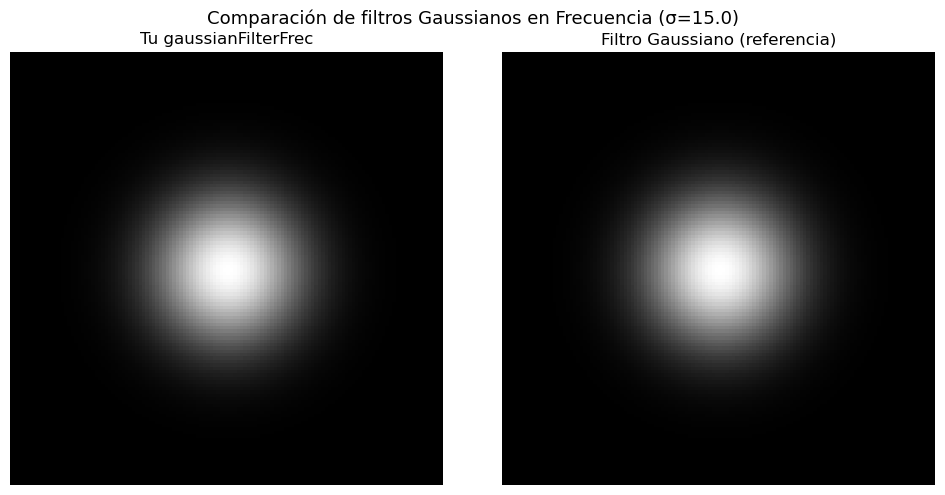

¿Son casi iguales?: True
Diferencia media absoluta: 6.82812783980193e-18


In [37]:
# --- Imagen de prueba ---
np.random.seed(0)
test_img = np.random.rand(128, 128)

# --- Parámetro de suavizado ---
sigma = 15.0

# --- Filtro tuyo ---
my_filter = gaussianFilterFrec(test_img, sigma)

# --- Filtro nativo (referencia, fórmula directa también) ---
H, W = test_img.shape[:2]
u = np.arange(-W//2, W//2)
v = np.arange(-H//2, H//2)
U, V = np.meshgrid(u, v)
D2 = U**2 + V**2
native_filter = np.exp(-D2 / (2 * (sigma**2)))

# --- Normalizamos ambos para comparar en escala ---
my_filter_norm = my_filter / np.max(my_filter)
native_filter_norm = native_filter / np.max(native_filter)

# --- Visualización lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(my_filter_norm, cmap='gray')
axes[0].set_title('Tu gaussianFilterFrec')
axes[0].axis('off')

axes[1].imshow(native_filter_norm, cmap='gray')
axes[1].set_title('Filtro Gaussiano (referencia)')
axes[1].axis('off')

plt.suptitle(f'Comparación de filtros Gaussianos en Frecuencia (σ={sigma})', fontsize=13)
plt.tight_layout()
plt.show()

# --- Comparación numérica ---
print("¿Son casi iguales?:", np.allclose(my_filter_norm, native_filter_norm, atol=1e-6))
print("Diferencia media absoluta:", np.mean(np.abs(my_filter_norm - native_filter_norm)))


###  Función 4: 

Implementar una función que aplique el filtro gaussiano en frecuencia anterior sobre una imagen, con el filtro del tamño de la imagen y un σ dado.


In [41]:

def ApplyGaussianFilterFrec(inImage, sigma):
    if inImage.ndim != 2:
        raise ValueError("Solo se admiten imágenes en escala de grises")

    F = fft2(inImage)
    Fshift = fftshift(F)
    H = gaussianFilterFrec(inImage, sigma)
    G = Fshift * H
    G_ishift = np.fft.ifftshift(G)
    outImage = np.real(ifft2(G_ishift))
    return outImage, np.log(1 + np.abs(Fshift * H))

NameError: name 'normalize' is not defined

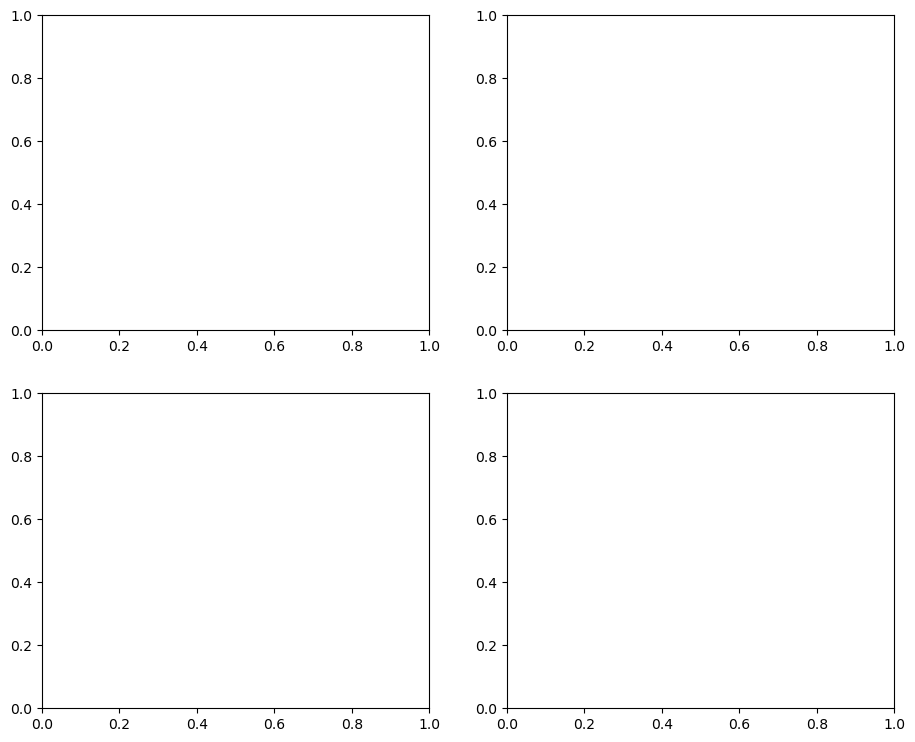

In [43]:
np.random.seed(0)
test_img = np.random.rand(128, 128)  # escala de grises

# ---------- Parámetro ----------
sigma = 10.0

# ---------- Tu resultado (imagen + espectro) ----------
my_img, my_spectrum = ApplyGaussianFilterFrec(test_img, sigma)

# ---------- Referencia en espacio (SciPy) ----------
ref_img = gaussian_filter(test_img, sigma=sigma)

# ---------- Espectro de la referencia (para comparar espectros) ----------
F_ref = fft2(ref_img)
F_ref_shift = fftshift(F_ref)
ref_spectrum = np.log1p(np.abs(F_ref_shift))

# ---------- Comparación visual: 2 filas x 2 columnas ----------
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# Fila 1: imágenes filtradas (tu método vs SciPy)
axes[0, 0].imshow(normalize(my_img), cmap='gray')
axes[0, 0].set_title('Tu ApplyGaussianFilterFrec (espacio)')
axes[0, 0].axis('off')

axes[0, 1].imshow(normalize(ref_img), cmap='gray')
axes[0, 1].set_title('SciPy gaussian_filter (espacio)')
axes[0, 1].axis('off')

# Fila 2: espectros (tu G vs. espectro de la imagen filtrada por SciPy)
axes[1, 0].imshow(normalize(my_spectrum), cmap='gray')
axes[1, 0].set_title('Tu espectro filtrado: log(1+|G|)')
axes[1, 0].axis('off')

axes[1, 1].imshow(normalize(ref_spectrum), cmap='gray')
axes[1, 1].set_title('Espectro de la imagen (SciPy): log(1+|F|)')
axes[1, 1].axis('off')

plt.suptitle(f'Filtro Gaussiano en Frecuencia vs Espacio (σ={sigma})', fontsize=13)
plt.tight_layout()
plt.show()

# ---------- Comparaciones numéricas ----------
# (mejor comparar sin normalizar)
print("¿Imágenes casi iguales?   ", np.allclose(my_img, ref_img, atol=1e-3))
print("MAE imágenes:             ", np.mean(np.abs(my_img - ref_img)))

print("¿Espectros casi iguales?  ", np.allclose(my_spectrum, ref_spectrum, atol=1e-3))
print("MAE espectros:            ", np.mean(np.abs(my_spectrum - ref_spectrum)))